In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nb
import random
from sklearn.linear_model import LinearRegression

In [2]:
mri_file = glob('/Volumes/DISK_IMG/100610/m100610_T1w.nii.gz')[0]
mri_im = nb.load(mri_file)
# mri_hdr = mri_im.header
mri_data = mri_im.get_fdata()

In [3]:
sos_file = glob('/Volumes/DISK_IMG/100610/Vp.nii.gz')[0]
sos_im = nb.load(sos_file)
# sos_hdr = sos_im.header
sos_data = sos_im.get_fdata()

In [52]:
coef, intercept, r2 = analyse_linearity(120)

/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_42226/1391427500.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  soft_sos = pd.Series([])
/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_42226/1391427500.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  soft_mri = pd.Series([])


In [50]:
def analyse_linearity(slice):
    # take just one slice nad make it a 1d vector
    mri_slice = pd.Series(np.array(mri_data[:,:,slice]).flatten())
    sos_slice = pd.Series(np.array(sos_data[:,:,slice]).flatten())
    # filtering background. value chosen looking at histogram
    better_mri = []
    better_sos = []
    for i in range(len(mri_slice)):
        if(mri_slice[i] >= 250):
            better_mri.append(mri_slice[i])
            better_sos.append(sos_slice[i])

    # take away skull by replacing any values over 1700 by 0s
    soft_sos = pd.Series([])
    soft_mri = pd.Series([])
    for i in range(len(better_sos)):
        if better_sos[i] < 1700:
            soft_sos = soft_sos.append(pd.Series(better_sos[i]))
            soft_mri = soft_mri.append(pd.Series(better_mri[i]))

    # lets do 70% train, 30% test
    train_X = pd.DataFrame()
    train_y = pd.DataFrame()
    train_indices = []
    for i in range(int(0.7*soft_mri.shape[0])):
        # get 70% of the set for training from the whole thing randomly
        r = random.randint(0, soft_mri.shape[0]-1) 
        train_indices.append(r)
        train_X = train_X.append(pd.Series(soft_mri.iloc[r]), ignore_index=True)
        train_y = train_y.append(pd.Series(soft_sos.iloc[r]), ignore_index=True)

    test_X = pd.DataFrame()
    test_y = pd.DataFrame()
    test_indices = []
    while test_y.shape[0] < 0.30*soft_mri.shape[0]:
        r = random.randint(0, soft_mri.shape[0]-1)

        if(r not in train_indices): 
            test_indices.append(r)
            test_X = test_X.append(pd.Series(soft_mri.iloc[r]), ignore_index=True)
            test_y = test_y.append(pd.Series(soft_sos.iloc[r]), ignore_index=True)

    train_X = np.array(train_X).reshape(-1,1)
    train_y = np.array(train_y).reshape(-1,1)
    test_X = np.array(test_X).reshape(-1,1)
    test_y = np.array(test_y).reshape(-1,1)

    linear = LinearRegression()
    linear.fit(train_X, train_y)
    preds = linear.predict(test_X)
    coef = linear.coef_
    intercept = linear.intercept_
    r2 = linear.score(test_y, preds)

    return coef, intercept, r2

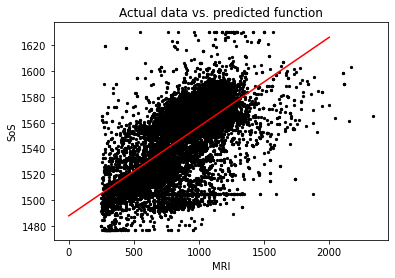

In [49]:
x = np.linspace(0,2000)
y = coef * x + intercept

plt.figure()
plt.scatter(test_X, test_y, c='black', s=5)
plt.plot(x, y[0], '-r')
plt.title("Actual data vs. predicted function")
plt.xlabel("MRI")
plt.ylabel("SoS")
plt.show()